# Tutorial

## Motivation


Project efforts such as the [Coupled Model Intercomparison Project (CMIP)](https://www.wcrp-climate.org/wgcm-cmip) and the [Community Earth System Model (CESM) Large Ensemble Project](http://www.cesm.ucar.edu/projects/community-projects/LENS/) produce a huge of amount climate data persisted on tape, disk storage, object storage components across multiple (in the order of ~ 300,000) data assets. These data assets are stored in netCDF and more recently [Zarr](https://zarr.readthedocs.io/en/stable/) formats. Finding, investigating, loading these assets into data array containers such as xarray can be a daunting task due to the large number of files a user may be interested in. Intake-esm aims to address these issues by providing necessary functionality for searching, discovering, data access/loading. 

## Overview 

`intake-esm` is a data cataloging utility built on top of [intake](https://github.com/intake/intake), [pandas](https://pandas.pydata.org/), and [xarray](https://xarray.pydata.org/en/stable/), and it's pretty awesome! 


## Opening a collection

First step is to point ``intake-esm`` to an ESM (Earth System Model) collection definition file, which is a JSON file that conforms to the [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec). The collection JSON file can be stored on a local filesystem or can be hosted on a remote server. When provided a link/path to an esm collection file, `intake-esm` establishes a link to a database (CSV file) that contains assets (e.g. file) locations and associated metadata (i.e., which experiement, model, the come from). 



<div class="alert alert-info">

**Note:** 
    
    
For demonstration purposes, we will be using the CMIP6 data hosted in Pangeo's Google Storage. For this data collection, we will be using the Pangeo cloud collection file stored [here](https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json).

    

More collection catalogs are listed [here](https://intake-esm.readthedocs.io/en/latest/faq.html#is-there-a-list-of-existing-catalogs). 
    
    
</div>


Because `intake-esm` is an `intake` plugin, the plugin automatically appears in the set of known
plugins in the intake registry, and an associated ``intake.open_esm_datastore`` function is created at import time.

In [1]:
import intake

In [2]:
intake.registry

{'yaml_file_cat': intake.catalog.local.YAMLFileCatalog,
 'yaml_files_cat': intake.catalog.local.YAMLFilesCatalog,
 'remote-xarray': intake_xarray.xarray_container.RemoteXarray,
 'netcdf': intake_xarray.netcdf.NetCDFSource,
 'opendap': intake_xarray.opendap.OpenDapSource,
 'rasterio': intake_xarray.raster.RasterIOSource,
 'xarray_image': intake_xarray.image.ImageSource,
 'zarr': intake_xarray.xzarr.ZarrSource,
 'catalog': intake.catalog.base.Catalog,
 'csv': intake.source.csv.CSVSource,
 'intake_remote': intake.catalog.base.RemoteCatalog,
 'ndzarr': intake.source.zarr.ZarrArraySource,
 'numpy': intake.source.npy.NPySource,
 'textfiles': intake.source.textfiles.TextFilesSource,
 'esm_datastore': intake_esm.core.esm_datastore}

In [3]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

pangeo-cmip6-ESM Collection with 142406 entries:
	> 14 activity_id(s)

	> 24 institution_id(s)

	> 55 source_id(s)

	> 99 experiment_id(s)

	> 123 member_id(s)

	> 28 table_id(s)

	> 243 variable_id(s)

	> 8 grid_label(s)

	> 142406 zstore(s)

	> 60 dcpp_init_year(s)

Since `intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable), it is possible to view the `pandas.DataFrame` as follows.

In [4]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,ch4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,clt,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
2,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,co2,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
3,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,evspsbl,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
4,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,hfls,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN


It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [5]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year'],
      dtype='object')

## Search and discovery

### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [6]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 99,
                   'values': ['piClim-CH4', 'piClim-NTCF', 'piClim-control',
                              'ssp370', 'piClim-2xDMS', 'piClim-2xdust',
                              'piClim-2xfire', 'piClim-2xss', 'piClim-BC',
                              'piClim-HC', 'piClim-N2O', 'piClim-OC',
                              'piClim-SO2', '1pctCO2-bgc', 'esm-ssp585',
                              'hist-bgc', 'amip-4xCO2', 'amip-future4K',
                              'amip-m4K', 'amip-p4K', 'amip', 'abrupt-2xCO2',
                              'abrupt-solp4p', 'abrupt-0p5xCO2', 'amip-lwoff',
                              'amip-p4K-lwoff', 'abrupt-solm4p', 'aqua-4xCO2',
                              'aqua-control-lwoff', 'aqua-control',
                              'aqua-p4K-lwoff', 'aqua-p4K', '1pctCO2',
                              'abrupt-4xCO2', 'historical', 'piControl',
                              'esm-hist', 'esm-piControl', 'ssp126', 'ssp245',


### Searching for specific datasets


One of the features supported in ``intake-esm`` is querying the collection catalog.
This feature is provided via the ``search()`` method. The ``search()`` method allows the user to
specify a query by using keyword arguments. This method returns a subset of the collection catalog
with all the entries that match the provided query.

Let's find all the dissolved oxygen data at annual frequency from the ocean for the `historical` and `ssp585` experiments.

In [7]:
%%time
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Oyr', variable_id='o2', 
                 grid_label='gn')
cat.df

CPU times: user 337 ms, sys: 67 ms, total: 404 ms
Wall time: 609 ms


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...,NaN
1,CMIP,CCCma,CanESM5,historical,r10i1p2f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...,NaN
2,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r11i1...,NaN
3,CMIP,CCCma,CanESM5,historical,r12i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r12i1...,NaN
4,CMIP,CCCma,CanESM5,historical,r13i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r13i1...,NaN
...,...,...,...,...,...,...,...,...,...,...
88,ScenarioMIP,CCCma,CanESM5,ssp585,r9i1p1f1,Oyr,o2,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r9...,NaN
89,ScenarioMIP,CCCma,CanESM5,ssp585,r9i1p2f1,Oyr,o2,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r9...,NaN
90,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Oyr,o2,gn,gs://cmip6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp5...,NaN
91,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,Oyr,o2,gn,gs://cmip6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp58...,NaN


In [8]:
len(cat.df), len(col.df)

(93, 142406)

You can get summary information by using `.nunique()` and `.unique()` methods:

In [9]:
pprint.pprint(cat.unique(columns=["source_id", "activity_id"]), indent=4)

{   'activity_id': {'count': 2, 'values': ['CMIP', 'ScenarioMIP']},
    'source_id': {   'count': 4,
                     'values': [   'CanESM5',
                                   'IPSL-CM6A-LR',
                                   'MIROC-ES2L',
                                   'MPI-ESM1-2-HR']}}


In [10]:
cat.nunique()

activity_id        2
institution_id     4
source_id          4
experiment_id      2
member_id         45
table_id           1
variable_id        1
grid_label         1
zstore            93
dcpp_init_year     0
dtype: int64

## Loading data

The best part about `intake-esm` is that it enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user!

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [11]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 7 group(s)


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [12]:
dset_dict.keys()

dict_keys(['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Oyr.gn', 'ScenarioMIP.MIROC.MIROC-ES2L.ssp585.Oyr.gn', 'ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.Oyr.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Oyr.gn', 'ScenarioMIP.CCCma.CanESM5.ssp585.Oyr.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn', 'CMIP.CCCma.CanESM5.historical.Oyr.gn'])

We can access a particular dataset as follows:

In [13]:
ds = dset_dict['CMIP.CCCma.CanESM5.historical.Oyr.gn']
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, lev: 45, member_id: 35, time: 165, vertices: 4)
Coordinates:
    time_bnds           (time, bnds) float64 dask.array<chunksize=(165, 2), meta=np.ndarray>
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * lev                 (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
  * time                (time) float64 182.5 547.5 912.5 ... 5.968e+04 6.004e+04
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * member_id           (member_id) <U9 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_latitude   (j, i, vertices) float6

Let’s create a quick plot for a slice of the data:

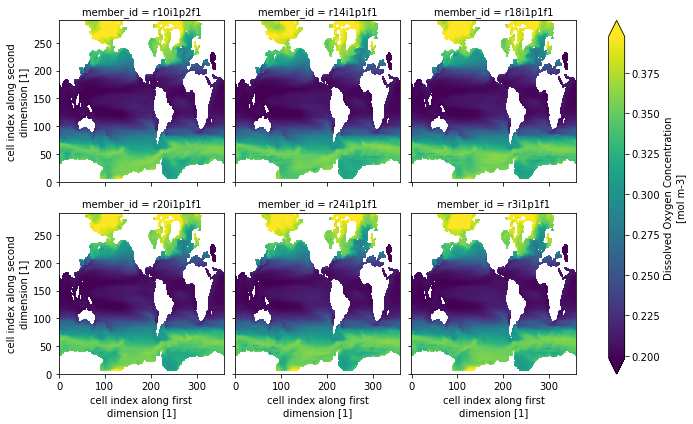

In [14]:
%matplotlib inline
ds.o2.isel(time=0, lev=0, member_id=range(1, 24, 4))\
      .plot(col='member_id', col_wrap=3, robust=True)

We can execute more searches against the original catalog and/or against a subset of the original catalog:

In [15]:
%%time
cat_fx = col.search(table_id='Ofx', grid_label='gn',
                    variable_id='volcello')
cat_fx.df.head()

CPU times: user 23.4 ms, sys: 1.79 ms, total: 25.2 ms
Wall time: 23.9 ms


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,BCC,BCC-ESM1,1pctCO2,r1i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/BCC/BCC-ESM1/1pctCO2/r1i1p1f1/...,NaN
1,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/MPI-M/MPI-ESM1-2-HR/historical...,NaN
2,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r5i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/MPI-M/MPI-ESM1-2-HR/historical...,NaN
3,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r6i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/MPI-M/MPI-ESM1-2-HR/historical...,NaN
4,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r8i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/MPI-M/MPI-ESM1-2-HR/historical...,NaN


In [16]:
%%time
a = cat_fx.search(source_id="CESM2")
a.df.head()

CPU times: user 2.02 ms, sys: 94 µs, total: 2.12 ms
Wall time: 2.07 ms


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Of...,NaN
1,CMIP,NCAR,CESM2,abrupt-4xCO2,r1i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1...,NaN
2,CMIP,NCAR,CESM2,esm-piControl,r1i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/NCAR/CESM2/esm-piControl/r1i1p...,NaN
3,CMIP,NCAR,CESM2,historical,r10i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r10i1p1f...,NaN
4,CMIP,NCAR,CESM2,historical,r11i1p1f1,Ofx,volcello,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r11i1p1f...,NaN


In [17]:
len(cat_fx.df), len(a.df)

(51, 25)

## Using custom preprocessing functions

When comparing many models it is often necessary to preprocess (e.g. rename certain variables) them before running some analysis step. The `preprocess` argument lets the user pass a function, which is executed for each loaded asset before aggregations.

In [18]:
cat_pp = col.search(experiment_id=['historical'], table_id='Oyr', variable_id='o2', 
                    grid_label='gn', source_id=['IPSL-CM6A-LR', 'CanESM5'],
                    member_id='r10i1p1f1')
cat_pp.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...,NaN
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN


In [19]:
# load the example
dset_dict_raw = cat_pp.to_dataset_dict(zarr_kwargs={'consolidated': True})

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 2 group(s)


In [20]:
for k, ds in dset_dict_raw.items():
    print(f"dataset key={k}\n\tdimensions={sorted(list(ds.dims))}\n")

dataset key=CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn
	dimensions=['axis_nbounds', 'member_id', 'nvertex', 'olevel', 'time', 'x', 'y']

dataset key=CMIP.CCCma.CanESM5.historical.Oyr.gn
	dimensions=['bnds', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']



Note that both models follow a different naming scheme. We can define a little helper function and pass it to ` .to_dataset_dict()` to fix this. For demonstration purposes we will focus on the vertical level dimension which is called `lev` in `CanESM5` and `olevel` in `IPSL-CM6A-LR`.

In [21]:
def helper_func(ds):
    ds = ds.copy()
    # a short example 
    if 'olevel' in ds.dims: 
        ds = ds.rename({'olevel':'lev'})
    return ds

In [22]:
dset_dict_fixed = cat_pp.to_dataset_dict(zarr_kwargs={'consolidated': True}, preprocess=helper_func)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 2 group(s)


In [23]:
for k, ds in dset_dict_fixed.items():
    print(f"dataset key={k}\n\tdimensions={sorted(list(ds.dims))}\n")

dataset key=CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn
	dimensions=['axis_nbounds', 'lev', 'member_id', 'nvertex', 'time', 'x', 'y']

dataset key=CMIP.CCCma.CanESM5.historical.Oyr.gn
	dimensions=['bnds', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']



This was just an example for one dimension. 


<div class="alert alert-info">

**Note:** 
    
Check out [cmip6-preprocessing](https://github.com/jbusecke/cmip6_preprocessing/blob/master/notebooks/tutorial_intake_esm_preprocessing.ipynb) for a full renaming function for all available CMIP6 models and some other utilities.
    
    
</div>




In [ ]:
import intake_esm
%load_ext watermark
%watermark -d -iv -m -g 